<a href="https://colab.research.google.com/github/PDBeurope/pdbe-api-training/blob/master/PDBe_yearly_release_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Making imports and setting global variables

In [1]:
import requests # used for getting data from a URL
from pprint import pprint # pretty print
import pandas as pd # used for turning results into mini databases
!pip install solrq
from solrq import Q # used to turn result queries into the right format
import numpy as np

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?" # the rest of the URL used for PDBe's search API.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


A function to get data from PDBe's search API

In [2]:
def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    makes a get request to the PDBe API
    :param dict search_dict: the terms used to search
    :param number_of_rows: number or rows to return - limited to 10
    :return dict: response JSON
    """
    if 'rows' not in search_dict:
        search_dict['rows'] = number_of_rows
    search_dict['wt'] = 'json'
    if group_pdb == True:
      search_dict['group'] = 'true'
      search_dict['group.field'] = 'pdb_id'
      search_dict['group.ngroups'] = 'true'
    pprint(search_dict)
    pprint(search_url)
    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print("[No data retrieved - %s] %s" % (response.status_code, response.text))

    return {}

Formatting the search terms
This will allow us to use human readable search terms and this function will make a URL that the search API can handle.

In [3]:
def format_search_terms(search_terms, filter_terms=None):
    ret = {'q': str(search_terms)}
    if filter_terms:
        fl = '{}'.format(','.join(filter_terms))
        ret['fl'] = fl
    return ret

Getting useful data out of the search
This function will run the search and will return a list of the results
Two versions - one returning entity results, the other grouping by PDB ID

In [4]:
def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    search_term = format_search_terms(search_terms, filter_terms)
    #print(search_term)
    response = make_request(search_term, number_of_rows, group_pdb)
    results = response.get('response', {}).get('docs', [])
    #results = response.get('response', {}).get('docs', [])
    #print('Number of results: {}'.format(len(results)))
    return results
    #return response

In [5]:
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    search_term = format_search_terms(search_terms, filter_terms)
    #print(search_term)
    response = make_request(search_term, number_of_rows, group_pdb)
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    results = []
    for group in preresults:
      docs = group.get('doclist', {}).get('docs', [])
      for doc in docs:
        results.append(doc)
    #print('Number of results: {}'.format(len(results)))
    return results

Search for released entries by year:
(added filtering to get back only fields interesting in this notebook)

In [6]:
search_terms = Q(status="REL", release_year=2022)
filter_terms = ['pdb_id', 'experimental_method', 'resolution', 'em_resolution', 'journal', 'refinement_software', 'synchrotron_site', 'em_electron_detection', 'cath_homologous_superfamily', 'assembly_composition', 'processing_site']
#all_results = run_search(search_terms, filter_terms, number_of_rows=100, group_pdb=False)
results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)
pprint(results[:5])

{'fl': 'pdb_id,experimental_method,resolution,em_resolution,journal,refinement_software,synchrotron_site,em_electron_detection,cath_homologous_superfamily,assembly_composition,processing_site',
 'group': 'true',
 'group.field': 'pdb_id',
 'group.ngroups': 'true',
 'q': 'status:REL AND release_year:2022',
 'rows': 20000,
 'wt': 'json'}
'https://www.ebi.ac.uk/pdbe/search/pdb/select?'
[{'assembly_composition': ['RNA/protein complex'],
  'experimental_method': ['X-ray diffraction'],
  'journal': 'Nat Chem Biol',
  'pdb_id': '6xjw',
  'processing_site': 'RCSB',
  'refinement_software': ['PHENIX'],
  'resolution': 1.918,
  'synchrotron_site': ['APS']},
 {'assembly_composition': ['protein structure'],
  'experimental_method': ['X-ray diffraction'],
  'journal': 'Nat Catal',
  'pdb_id': '6ywu',
  'processing_site': 'PDBE',
  'refinement_software': ['REFMAC'],
  'resolution': 1.1,
  'synchrotron_site': ['PETRA III, EMBL c/o DESY']},
 {'assembly_composition': ['protein structure'],
  'experiment

Change lists to strings to help with graphing

In [7]:
def change_lists_to_strings(results):
    """
    input - list of results from search
    output - list of results with lists changed into strings
    """
    for row in results:
        for data in row:
            if type(row[data]) == list:
                # if there are any numbers in the list change them into strings
                row[data] = [str(a) for a in row[data]]
                # unique and sort the list and then change the list into a string
                row[data] = ','.join(sorted(list(set(row[data]))))
                
    return results

We can use a Python package called Pandas to change the results into a mini database - called a DataFrame.

In [8]:
def pandas_dataset(list_of_results):
    results = change_lists_to_strings(list_of_results) # we have added our function to change lists to strings
    df = pd.DataFrame(results)

    return df

Functions to count results and plot them on a graph

In [9]:
def pandas_count(list_of_results, column_to_group_by):
    df = pandas_dataset(list_of_results)
    ds = df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)
    return ds
    
def pandas_plot(list_of_results, column_to_group_by, graph_type='bar', top10=False):
    ds = pandas_count(list_of_results=list_of_results, column_to_group_by=column_to_group_by)
    if top10 == True:
      ds = ds.iloc[:10]
    ds.plot(kind=graph_type)

def pandas_plot_top10(list_of_results, column_to_group_by, graph_type='bar'):
    ds = pandas_count(list_of_results=list_of_results, column_to_group_by=column_to_group_by)
    ds = ds.iloc[:10]
    ds.plot(kind=graph_type)

def pandas_mean_plot(list_of_results, column_to_group_by, graph_type='bar'):
    df = pandas_dataset(list_of_results)
    df.groupby(column_to_group_by).mean().plot(kind=graph_type)


Basic plotting of experimental method per year

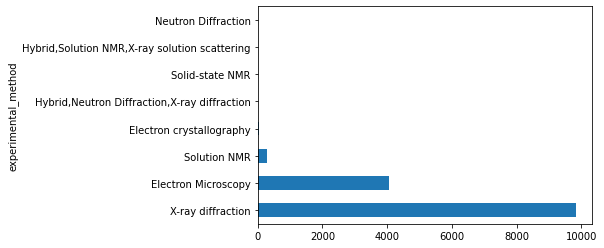

In [25]:
pandas_plot(list_of_results=results, column_to_group_by='experimental_method', graph_type='barh')

Basic plotting of journals per year

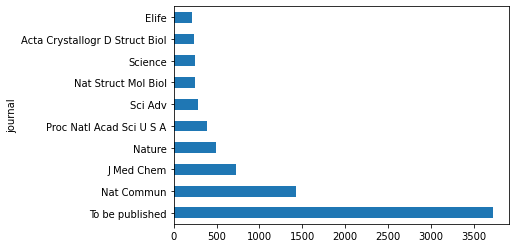

In [11]:
pandas_plot(list_of_results=results, column_to_group_by='journal', graph_type='barh', top10=True)

Basic plotting of refinement_software per year

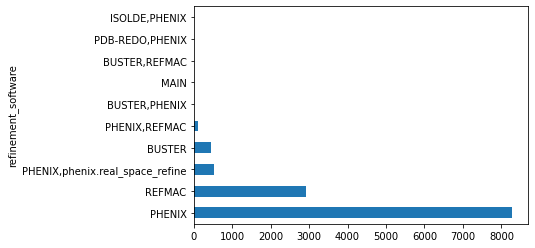

In [12]:
pandas_plot(list_of_results=results, column_to_group_by='refinement_software', graph_type='barh', top10=True)

Basic plotting of synchrotron_site per year

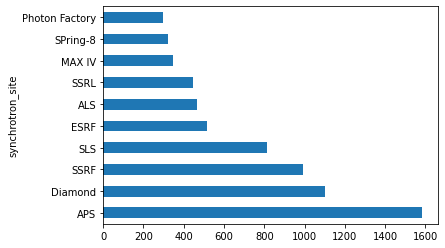

In [13]:
pandas_plot(list_of_results=results, column_to_group_by='synchrotron_site', graph_type='barh', top10=True)

Basic plotting of em_electron_detection per year

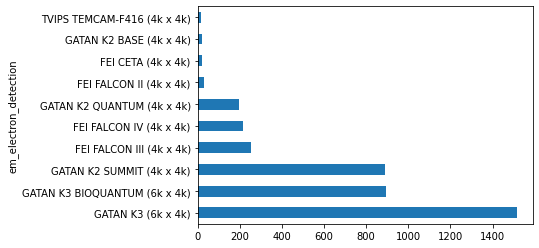

In [14]:
pandas_plot(list_of_results=results, column_to_group_by='em_electron_detection', graph_type='barh', top10=True)

Basic plotting of assembly_composition per year

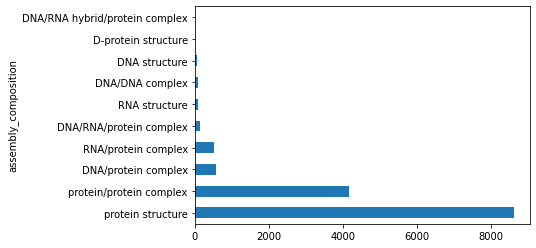

In [15]:
pandas_plot(list_of_results=results, column_to_group_by='assembly_composition', graph_type='barh', top10=True)

Basic plotting of processing_site per year

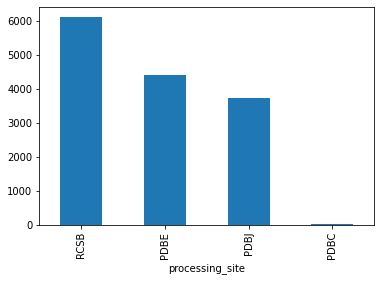

In [16]:
pandas_plot(list_of_results=results, column_to_group_by='processing_site')

Setting up new search for only X-ray

In [17]:
search_terms = Q(status="REL", release_year=2022, experimental_method='X-ray diffraction')
filter_terms = ['pdb_id','resolution']
#all_results = run_search(search_terms, filter_terms, number_of_rows=100, group_pdb=False)
xray_results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)
pprint(xray_results[:5])

{'fl': 'pdb_id,resolution',
 'group': 'true',
 'group.field': 'pdb_id',
 'group.ngroups': 'true',
 'q': 'status:REL AND release_year:2022 AND experimental_method:X\\-ray\\ '
      'diffraction',
 'rows': 20000,
 'wt': 'json'}
'https://www.ebi.ac.uk/pdbe/search/pdb/select?'
[{'pdb_id': '6xjw', 'resolution': 1.918},
 {'pdb_id': '6ywu', 'resolution': 1.1},
 {'pdb_id': '6ywt', 'resolution': 1.05},
 {'pdb_id': '6zkx', 'resolution': 2.17},
 {'pdb_id': '6xjq', 'resolution': 1.708}]


Setting function to plotted binned data

In [18]:
def pandas_plot_binned(list_of_results, column_to_group_by, bin_cat, bin_range, graph_type='bar'):
    df = pandas_dataset(list_of_results)
    df[bin_cat] = pd.cut(df[column_to_group_by],bin_range)
    #print(df.head(5))
    ds = df.groupby(bin_cat)['pdb_id'].nunique()
    #print(ds)
    ds.plot(kind=graph_type)


Plot X-ray resolution by bins

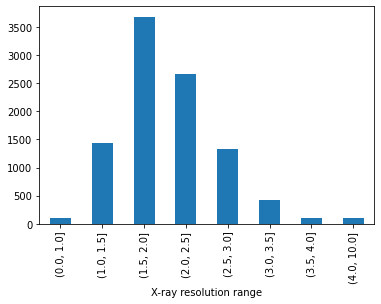

In [19]:
bin_cat = 'X-ray resolution range'
bin_range = [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 10]
pandas_plot_binned(list_of_results=xray_results, column_to_group_by='resolution', bin_cat=bin_cat, bin_range=bin_range)

Setting up new search for only EM

In [20]:
search_terms = Q(status="REL", release_year=2022, experimental_method='Electron Microscopy')
filter_terms = ['pdb_id','em_resolution']
#all_results = run_search(search_terms, filter_terms, number_of_rows=100, group_pdb=False)
em_results = run_grouped_search(search_terms, filter_terms, number_of_rows=10000, group_pdb=True)
pprint(em_results[:5])

{'fl': 'pdb_id,em_resolution',
 'group': 'true',
 'group.field': 'pdb_id',
 'group.ngroups': 'true',
 'q': 'status:REL AND release_year:2022 AND experimental_method:Electron\\ '
      'Microscopy',
 'rows': 10000,
 'wt': 'json'}
'https://www.ebi.ac.uk/pdbe/search/pdb/select?'
[{'em_resolution': [3.0], 'pdb_id': '6xn3'},
 {'em_resolution': [2.97], 'pdb_id': '6xn5'},
 {'em_resolution': [2.8], 'pdb_id': '7b5i'},
 {'em_resolution': [2.7], 'pdb_id': '7ban'},
 {'em_resolution': [7.2], 'pdb_id': '7b4m'}]


In [21]:
def pandas_plot_binned_float(list_of_results, column_to_group_by, bin_cat, bin_range, graph_type='bar'):
    df = pandas_dataset(list_of_results)
    df[column_to_group_by] = pd.to_numeric(df[column_to_group_by])
    df[bin_cat] = pd.cut(df[column_to_group_by],bin_range)
    #print(df.head(5))
    ds = df.groupby(bin_cat)['pdb_id'].nunique()
    #print(ds)
    ds.plot(kind=graph_type)


Plot EM resolution by bins

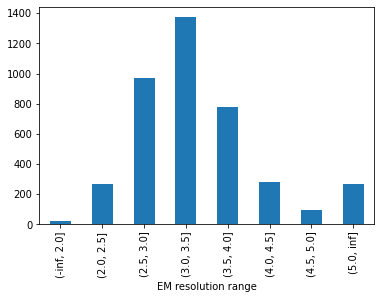

In [22]:
bin_cat = 'EM resolution range'
bin_range = [-float("inf"), 2, 2.5, 3, 3.5, 4, 4.5, 5, float("inf")]
pandas_plot_binned_float(list_of_results=em_results, column_to_group_by='em_resolution', bin_cat=bin_cat, bin_range=bin_range)